### Librerias

In [1]:
# Standard imports
import numpy as np
import os
import pandas as pd
import sys
import torch
import torch.nn.functional as F

# Visualization imports
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import seaborn as sns

# Machine learning imports
from scipy import stats
from sklearn.metrics import mean_squared_error as mse, median_absolute_error as mae, r2_score
from torch import nn
from utils.models import GWGCN, GCN
from utils.laplacian import prepare_adjacency_matrix, check_symmetric

# Spatial analysis imports
import esda
import geopandas as gpd
import skgstat as skg
import splot.esda as esdaplot
from esda.getisord import G_Local
from esda.moran import Moran_Local
from libpysal.weights import lag_spatial
from shapely.geometry import Point

### Configuración

Vamos a configurar CUDA para aprovechar la GPU.

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
torch.backends.cuda.matmul.fp32_precision = (
    "ieee"  # torch.backends.cuda.matmul.allow_tf32 = True
)
torch.backends.cudnn.conv.fp32_precision = (
    "tf32"  # torch.backends.cudnn.allow_tf32 = True
)
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [3]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print(
    "__CUDA VERSION",
)
print("__CUDNN VERSION:", torch.backends.cudnn.version())
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())
#! nvidia-smi

__Python VERSION: 3.12.11 (main, Sep  5 2025, 19:35:43) [GCC 13.3.0]
__pyTorch VERSION: 2.9.0+cu128
__CUDA VERSION
__CUDNN VERSION: 91002
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


Configuramos un diccionaro con algunas variables que usaremos durante el entrenamiento:

In [4]:
# Configuration dictionary
config = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "graph": {
        "adj": {
            "k": 15,
        },
    },
    "model": {
        "hidden_layers": [16],
        "dropouts": [0.3],
        "learning_rate": 1e-3,
        "weight_decay_ratio": 0.1,
    },
    "training": {
        "epochs": 30000,
        "print_interval": 1000,
        "error_type": "MSE"
    },
}

In [5]:
device = config['device']
device

device(type='cuda')

In [6]:
def step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> float:
    """
    Perform a training step with the given model and optimizer.
    Trains the model on the specified indices.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the training samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        float: The mean loss value for the training step.
    """
    model.train()
    optimizer.zero_grad()
    output = model(input_tensor, adj)
    loss = F.mse_loss(output[idx], target_tensor[idx])
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
def evaluate_error(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
    error_type: str,
) -> float:
    """
    Evaluate the model's performance on a validation set using a user defined rror.

    Args:
        model (nn.Module): The neural network model to evaluate.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the validation samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.
        error_type(str): The error type to use. Can be "MSE" or "MAPE".

    Returns:
        float: The mean loss on the validation set.
    """
    model.eval()
    # with torch.no_grad():
    with torch.inference_mode():
        output = model(input_tensor, adj)
        preds = output[idx]
        targets = target_tensor[idx]
        if error_type == "MSE":
            error = F.mse_loss(preds, targets)
        elif error_type == "RMSE":
            error = torch.sqrt(F.mse_loss(preds, targets))
        else:
            raise ValueError("Invalid error type. Must be 'MSE' or 'RSME'.")
    return error.item()

In [8]:
def return_results(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate and return the model's predictions and corresponding targets.

    Args:
        model (nn.Module): The trained neural network model.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices for which to generate predictions.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the predicted values
        and the ground truth values as NumPy arrays.
    """
    model.eval()
    # with torch.no_grad():
    with torch.inference_mode():
        output = model(input_tensor, adj)
    predictions = output[idx].cpu().detach().numpy()
    targets = target_tensor[idx].cpu().detach().numpy()
    return predictions, targets

#### Carga de Datos

In [9]:
db = pd.read_csv("well_frac_prod_data_VM.csv")
db = db.convert_dtypes()
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   well_id               1234 non-null   Int64  
 1   month_x               1234 non-null   Int64  
 2   year_x                1234 non-null   Int64  
 3   well_name             1234 non-null   string 
 4   company               1234 non-null   string 
 5   basin_x               1234 non-null   string 
 6   field                 1234 non-null   string 
 7   formation_x           1234 non-null   string 
 8   reservoir_type        1234 non-null   string 
 9   reservoir_subtype     1234 non-null   string 
 10  lateral_length_ft     1234 non-null   Float64
 11  number_stages         1234 non-null   Int64  
 12  proppant_pumped_lb    1234 non-null   Float64
 13  fluid_pumped_bbl      1234 non-null   Float64
 14  maximum_pressure_psi  1234 non-null   Float64
 15  horse_power_hp       

In [10]:
db.columns

Index(['well_id', 'month_x', 'year_x', 'well_name', 'company', 'basin_x',
       'field', 'formation_x', 'reservoir_type', 'reservoir_subtype',
       'lateral_length_ft', 'number_stages', 'proppant_pumped_lb',
       'fluid_pumped_bbl', 'maximum_pressure_psi', 'horse_power_hp',
       'company_id', 'year_y', 'month_y', 'oil_prod_m3', 'gas_prod_km3',
       'water_prod_m3', 'water_inj_m3', 'well_type', 'entry_date', 'depth_m',
       'formation_y', 'basin_y', 'province', 'Xcoor', 'Ycoor', 'month_count',
       'cum_oil_m3', 'cum_gas_km3', 'cum_water_m3', 'cum_oil_km3',
       'cum_gas_Mm3', 'cum_water_km3'],
      dtype='object')

In [11]:
db.head()

,well_id,month_x,year_x,well_name,company,basin_x,field,formation_x,reservoir_type,reservoir_subtype,...,province,Xcoor,Ycoor,month_count,cum_oil_m3,cum_gas_km3,cum_water_m3,cum_oil_km3,cum_gas_Mm3,cum_water_km3
0,154188,2,2015,YPF.Nq.EOr-22(h),YPF S.A.,NEUQUINA,EL OREJANO,vaca muerta,NO CONVENCIONAL,SHALE,...,Neuquén,-69.220829,-37.963007,12,0.0,4548.23,373.87,0.0,4.54823,0.37387
1,156550,3,2016,YPF.Nq.LACh-10(h),YPF S.A.,NEUQUINA,LA AMARGA CHICA,vaca muerta,NO CONVENCIONAL,SHALE,...,Neuquén,-68.665429,-38.265802,12,8807.09,1264.61,2424.2,8.80709,1.26461,2.4242
2,156473,2,2016,YPF.Nq.LACh-12(h),YPF S.A.,NEUQUINA,LA AMARGA CHICA,vaca muerta,NO CONVENCIONAL,SHALE,...,Neuquén,-68.631737,-38.303168,12,5416.05,830.07,509.36,5.41605,0.83007,0.50936
3,156320,1,2016,YPF.Nq.LACh-13(h),YPF S.A.,NEUQUINA,LA AMARGA CHICA,vaca muerta,NO CONVENCIONAL,SHALE,...,Neuquén,-68.631733,-38.303708,12,5884.04,863.01,2451.87,5.88404,0.86301,2.45187
4,156967,7,2016,YPF.Nq.LACh-21(h),YPF S.A.,NEUQUINA,LA AMARGA CHICA,vaca muerta,NO CONVENCIONAL,SHALE,...,Neuquén,-68.662221,-38.098993,12,13511.4,1017.23,2628.68,13.5114,1.01723,2.62868


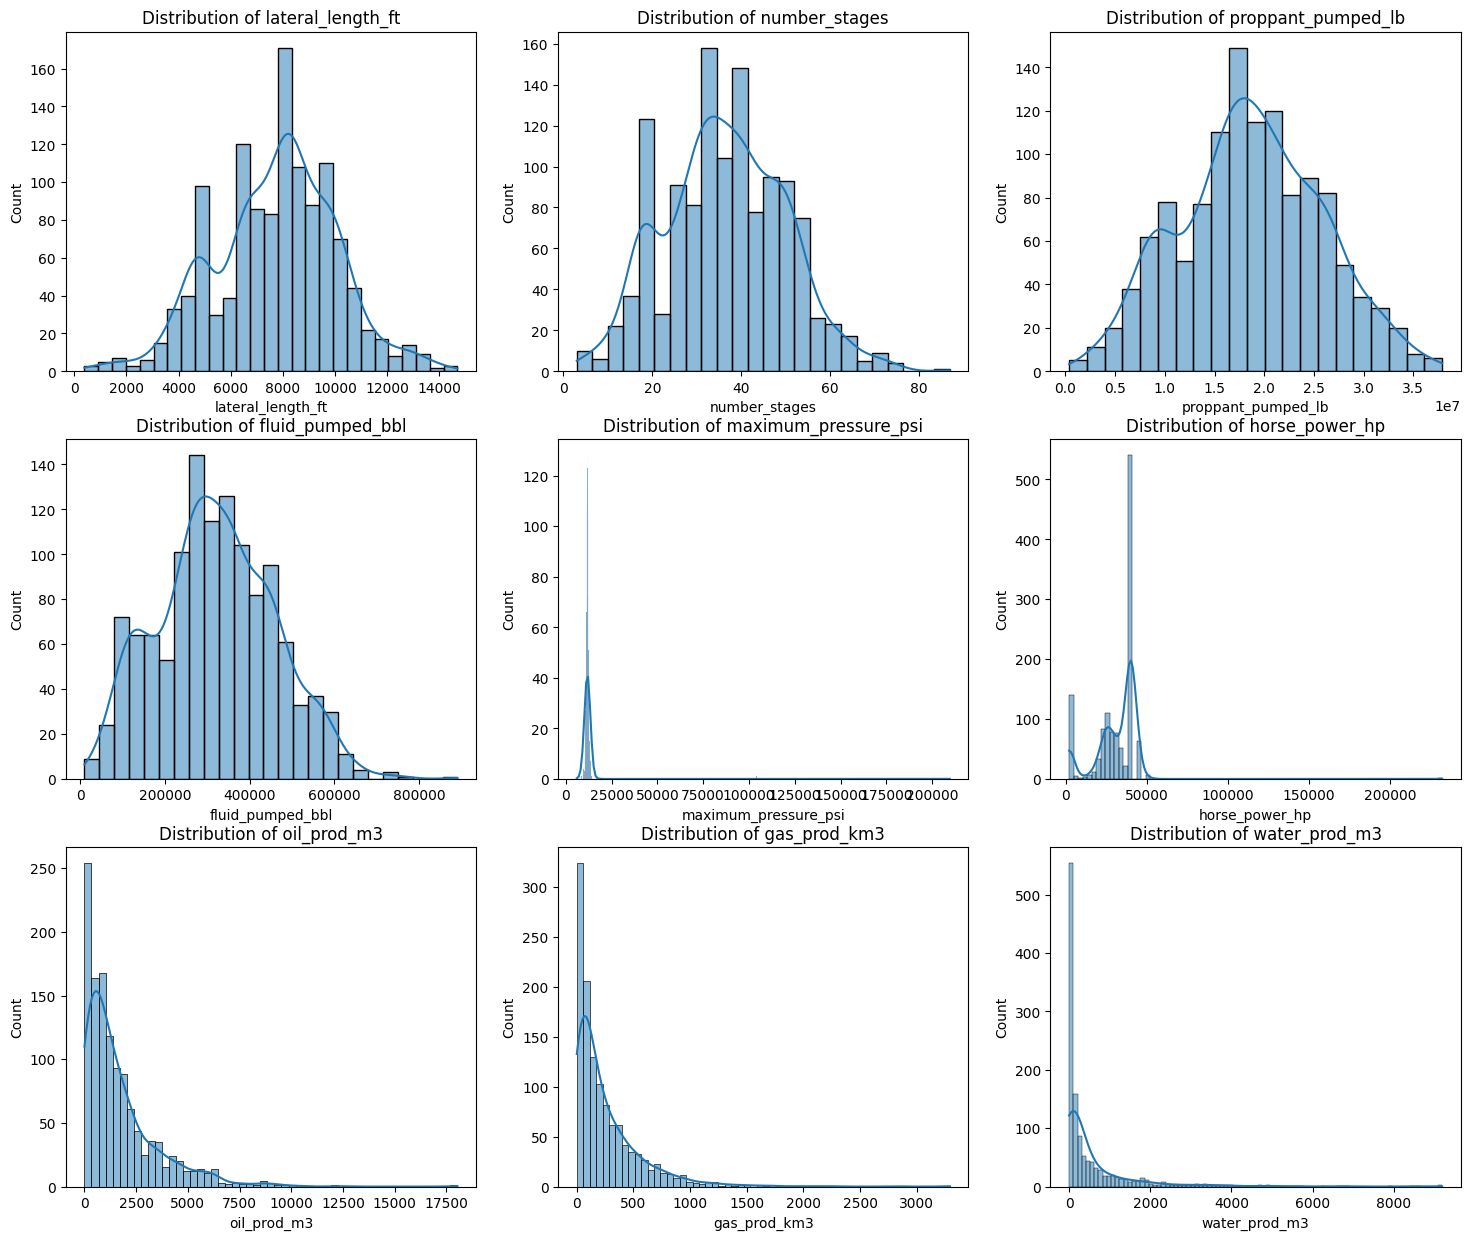

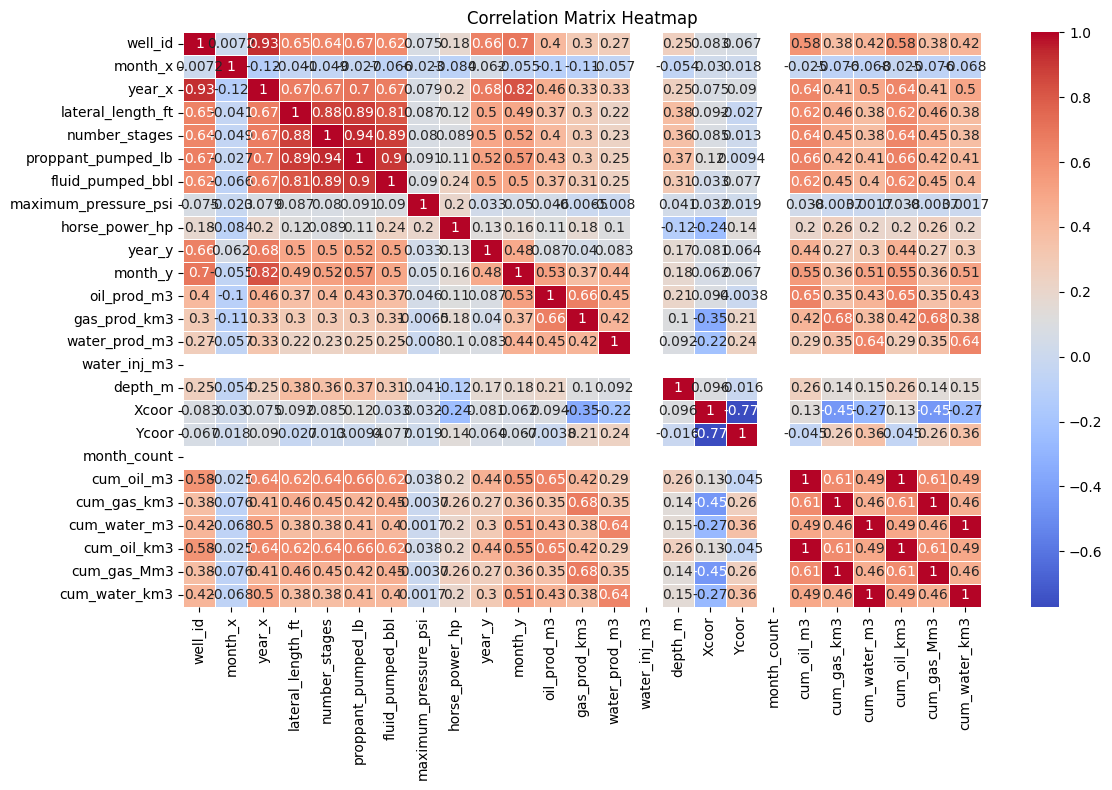

In [12]:
# 1. Summary Statistics
summary_stats = db.describe()

# 2. Missing Values Check
missing_values = db.isnull().sum()

# 3. Correlation Matrix
correlation_matrix = db.select_dtypes(include=[np.number]).corr()

# Plotting
# Numerical Feature Distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
numerical_features = [
    "lateral_length_ft",
    "number_stages",
    "proppant_pumped_lb",
    "fluid_pumped_bbl",
    "maximum_pressure_psi",
    "horse_power_hp",
    "oil_prod_m3",
    "gas_prod_km3",
    "water_prod_m3",
]

for ax, feature in zip(axes.flatten(), numerical_features):
    sns.histplot(db[feature], kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")


# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [13]:
summary_stats

,well_id,month_x,year_x,lateral_length_ft,number_stages,proppant_pumped_lb,fluid_pumped_bbl,maximum_pressure_psi,horse_power_hp,year_y,...,depth_m,Xcoor,Ycoor,month_count,cum_oil_m3,cum_gas_km3,cum_water_m3,cum_oil_km3,cum_gas_Mm3,cum_water_km3
count,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,...,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0,1234.0
mean,162189.707455,6.485413,2020.706645,7741.58842,36.364668,18659539.865612,321326.099399,11959.917323,30954.961468,2023.285251,...,5380.856329,-68.654746,-38.265792,12.0,21875.370961,3416.040336,7329.575275,21.875371,3.41604,7.329575
std,3500.038513,3.333119,2.756958,2297.767052,13.47341,7154005.445788,138361.3064,6267.246851,13896.827385,1.893257,...,1334.45067,0.177925,0.220282,0.0,14021.139222,3013.397815,8480.873969,14.021139,3.013398,8.480874
min,137008.0,1.0,2011.0,390.439,3.0,368171.54,10164.339424,5946.93,2000.0,2014.0,...,0.0,-69.476613,-38.833272,12.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,160865.25,4.0,2019.0,6417.636,27.0,13923330.015264,229490.153604,11348.820839,25000.0,2022.0,...,5018.75,-68.691621,-38.371613,12.0,11345.405,1484.3325,1986.893433,11.345405,1.484332,1.986893
50%,163018.5,7.0,2021.0,8010.5615,36.0,18540964.431,319072.519366,11734.507018,38000.0,2024.0,...,5617.0,-68.638624,-38.320306,12.0,20414.17,2666.11,4475.4135,20.41417,2.66611,4.475414
75%,164640.75,9.0,2023.0,9324.602,46.0,23816299.043212,421834.361966,12100.005428,40000.0,2025.0,...,6078.0,-68.561192,-38.216449,12.0,30493.3,4326.47175,9593.9475,30.4933,4.326472,9.593948
max,165742.0,12.0,2024.0,14689.037,87.0,37896976.876,890849.188845,209640.559334,232159.2892,2025.0,...,7784.0,-68.294423,-37.085457,12.0,182645.925,22014.18,94675.383,182.645925,22.01418,94.675383


In [14]:
laplacian_knn, knn, a_knn_connected = prepare_adjacency_matrix(db, config['graph']['adj']['k'], True, 'hard')

The weights matrix is fully connected.


In [15]:
check_symmetric(np.array(laplacian_knn))

True

Veamos el resultado de la construcción del grafo:

In [16]:
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(a_knn_connected)

# Extract coordinates from 'Xcoor' and 'Ycoor' columns
positions = {i: (row["Xcoor"], row["Ycoor"]) for i, row in db.iterrows()}

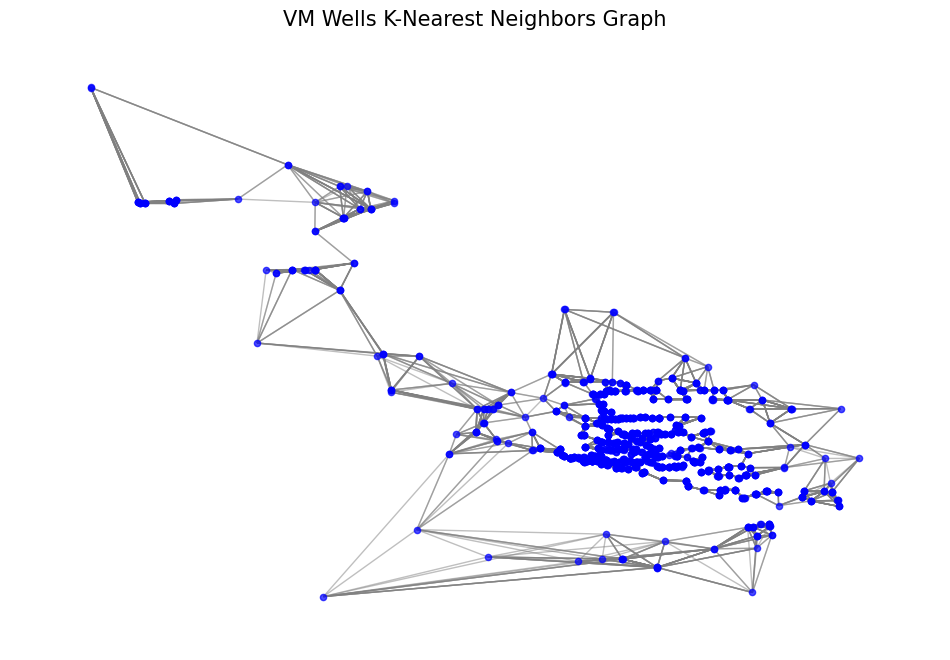

In [17]:
# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(G, pos=positions, alpha=0.5, edge_color="gray")
nx.draw_networkx_nodes(G, pos=positions, node_size=20, node_color="blue", alpha=0.7)
plt.axis("off")
plt.title("VM Wells K-Nearest Neighbors Graph", fontsize=15)
plt.show()

Podemos graficar de manera interactiva:

In [18]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = positions[edge[0]]
    x1, y1 = positions[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = [positions[node][0] for node in G.nodes()]
node_y = [positions[node][1] for node in G.nodes()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=5,
        color=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Coloring nodes based on degree
node_adjacencies = [G.degree(node) for node in G.nodes()]
node_trace.marker.color = node_adjacencies

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='VM Wells K-Nearest Neighbors Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

In [19]:
adj = torch.FloatTensor(laplacian_knn).to(device)

In [20]:
# the list of independent variables used for regression (may be used for feature engineering)
variable_names = [
    "lateral_length_ft",
    "number_stages",
    "proppant_pumped_lb",
    "fluid_pumped_bbl",
    "gas_prod_km3",
    "oil_prod_m3",
    "water_prod_m3",
    "depth_m",
    "cum_gas_Mm3",
    "cum_water_km3",
]


# Min-Max scaling function
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())


# Apply Min-Max scaling to each feature
for var in variable_names:
    if var in db.columns:
        # Convert to float and apply scaling
        db[var] = min_max_scale(db[var])

In [21]:
# db["cum_oil_km3"] = np.log1p(db["cum_oil_km3"])
db["cum_oil_km3"] = min_max_scale(db["cum_oil_km3"])

In [22]:
### Params settings for the model on limited Xs
n_labels = 1  # #output feature dimension
n_features = len(variable_names)  # #input feature dimensional vector
num_nodes = adj.size(0)

In [23]:
N = len(db)
perm = torch.randperm(N, device=device)
n_train = int(0.7 * N)
n_val = int(0.15 * N)
n_test = N - n_train - n_val

idx_train = perm[:n_train]
idx_val = perm[n_train : n_train + n_val]
idx_test = perm[n_train + n_val :]

In [24]:
### The observations for data regression
x_tensor = torch.FloatTensor(db[variable_names].values.tolist()).to(device)
y_tensor = torch.FloatTensor(db[['cum_oil_km3']].values.tolist()).to(device)
idx_all = torch.LongTensor(db.index.values).to(device)

In [25]:
class ModelFactory:
    """Factory class to create different types of GCN models."""

    @staticmethod
    def create(
        model_type: str,
        in_features: int,
        out_features: int,
        hidden: list,
        dropouts: list,
        num_nodes: int
    ) -> nn.Module:
        if model_type == "GCN":
            return GCN(in_features, out_features, hidden, dropouts).to(device)
        elif model_type == "GWGCN":
            return GWGCN(
                in_features, out_features, hidden, dropouts, num_nodes
            ).to(device)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

#### Training

In [26]:
model_type = "GWGCN"  # or "GCN"
model = ModelFactory.create(
    model_type,
    n_features,
    n_labels,
    config["model"]["hidden_layers"],
    config["model"]['dropouts'],
    num_nodes
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["model"]["learning_rate"],
    weight_decay=config["model"]["learning_rate"] * config["model"]["weight_decay_ratio"],
    amsgrad=False
)

In [27]:
lowest_mean_val_error = np.inf
min_val_erroroch = -1
train_loss_arr = []
error_arr = []

for i in range(config["training"]["epochs"]):
    train_loss = step(model, optimizer, x_tensor, idx_train, y_tensor, adj)
    train_loss_arr.append(train_loss)
    val_error = evaluate_error(
        model, x_tensor, idx_val, y_tensor, adj, config["training"]["error_type"]
    )
    error_arr.append(val_error)

    if val_error < lowest_mean_val_error:
        lowest_mean_val_error = val_error
        min_val_error_epoch = i

    if (
        i % config["training"]["print_interval"] == 0
        or i == config["training"]["epochs"] - 1
    ):
        print(
            f"epoch: {i} --train_loss: {train_loss:.4f} --val_error: {val_error:.4f}"
        )

epoch: 0 --train_loss: 2199.5979 --val_error: 2268.7947
epoch: 1000 --train_loss: 25.6632 --val_error: 27.3180
epoch: 2000 --train_loss: 1.7481 --val_error: 1.9275
epoch: 3000 --train_loss: 0.2125 --val_error: 0.2236
epoch: 4000 --train_loss: 0.0653 --val_error: 0.0676
epoch: 5000 --train_loss: 0.0285 --val_error: 0.0304
epoch: 6000 --train_loss: 0.0173 --val_error: 0.0205
epoch: 7000 --train_loss: 0.0139 --val_error: 0.0167
epoch: 8000 --train_loss: 0.0108 --val_error: 0.0135
epoch: 9000 --train_loss: 0.0088 --val_error: 0.0103
epoch: 10000 --train_loss: 0.0072 --val_error: 0.0084
epoch: 11000 --train_loss: 0.0062 --val_error: 0.0076
epoch: 12000 --train_loss: 0.0055 --val_error: 0.0068
epoch: 13000 --train_loss: 0.0051 --val_error: 0.0064
epoch: 14000 --train_loss: 0.0041 --val_error: 0.0058
epoch: 15000 --train_loss: 0.0035 --val_error: 0.0054
epoch: 16000 --train_loss: 0.0030 --val_error: 0.0050
epoch: 17000 --train_loss: 0.0029 --val_error: 0.0046
epoch: 18000 --train_loss: 0.0029

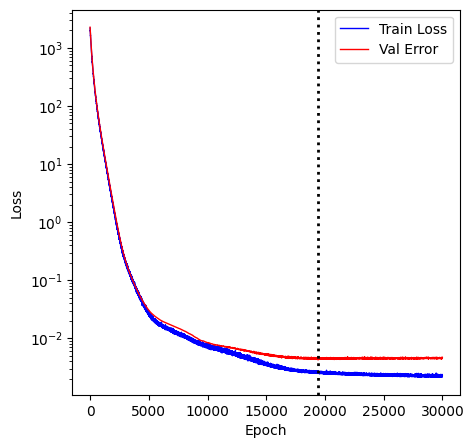

In [28]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(train_loss_arr, lw=1, color="b", alpha=1, label="Train Loss")
ax.plot(error_arr, lw=1, color="r", alpha=1, label="Val Error")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend(loc='upper right')
plt.axvline(min_val_error_epoch, linestyle="dotted", linewidth=2, color="black")
plt.show()

In [29]:
output, target = return_results(model, x_tensor, idx_all, y_tensor, adj)

In [30]:
idx_train = idx_train.cpu().detach().numpy()
idx_test = idx_test.cpu().detach().numpy()

In [31]:
output_train, target_train = output[idx_train], target[idx_train]

In [32]:
print(f' MSE Train: {mse(output_train, target_train)}, RMSE Train: {np.sqrt(mse(output_train, target_train))}')

 MSE Train: 0.0020499746315181255, RMSE Train: 0.04527664554180362


In [33]:
residuals_train = (output_train - target_train).flatten()

In [34]:
output_test, target_test = output[idx_test], target[idx_test]

In [35]:
print(f' MSE Test: {mse(output_test, target_test)}, RMSE Test: {np.sqrt(mse(output_test, target_test))}')

 MSE Test: 0.004321462009102106, RMSE Test: 0.06573782783985264


In [36]:
residuals_test = (output_test - target_test).flatten()

In [37]:
residuals = np.zeros(N)
residuals[idx_train] = residuals_train
residuals[idx_test] = residuals_test

In [38]:
dbplot = db.loc[:, ["cum_oil_km3", "Xcoor", "Ycoor"]].copy()
dbplot["pred"] = np.squeeze(output)
dbplot["error"] = dbplot["pred"] - dbplot["cum_oil_km3"]
dbplot_train = dbplot.iloc[idx_train]
dbplot_test = dbplot.iloc[idx_test]

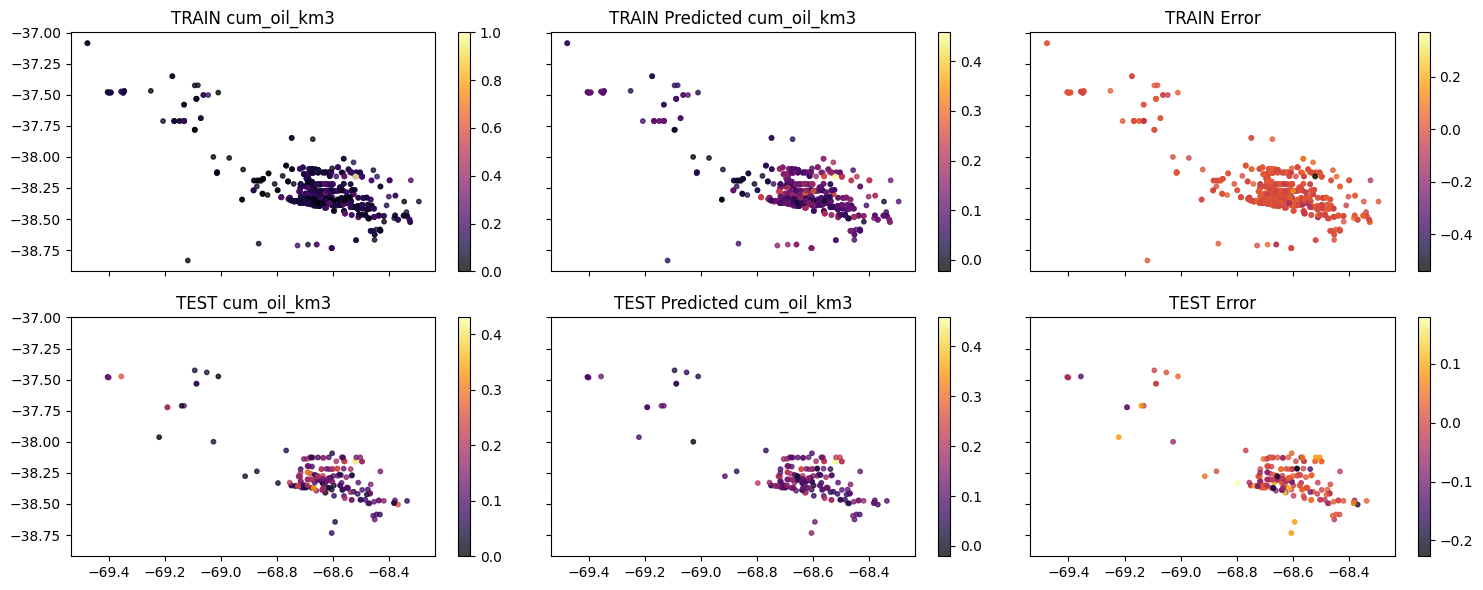

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
ax = ax.ravel()

scatter1 = ax[0].scatter(
    dbplot_train["Xcoor"],
    dbplot_train["Ycoor"],
    c=dbplot_train["cum_oil_km3"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter1, ax=ax[0])
ax[0].set_title("TRAIN cum_oil_km3")

scatter2 = ax[1].scatter(
    dbplot_train["Xcoor"],
    dbplot_train["Ycoor"],
    c=dbplot_train["pred"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter2, ax=ax[1])
ax[1].set_title("TRAIN Predicted cum_oil_km3")

scatter3 = ax[2].scatter(
    dbplot_train["Xcoor"],
    dbplot_train["Ycoor"],
    c=dbplot_train["error"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter3, ax=ax[2])
ax[2].set_title("TRAIN Error")

scatter4 = ax[3].scatter(
    dbplot_test["Xcoor"],
    dbplot_test["Ycoor"],
    c=dbplot_test["cum_oil_km3"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter4, ax=ax[3])
ax[3].set_title("TEST cum_oil_km3")

scatter5 = ax[4].scatter(
    dbplot_test["Xcoor"],
    dbplot_test["Ycoor"],
    c=dbplot_test["pred"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter5, ax=ax[4])
ax[4].set_title("TEST Predicted cum_oil_km3")

scatter6 = ax[5].scatter(
    dbplot_test["Xcoor"],
    dbplot_test["Ycoor"],
    c=dbplot_test["error"],
    cmap="inferno",
    s=10,
    alpha=0.75,
)
fig.colorbar(scatter6, ax=ax[5])
ax[5].set_title("TEST Error")

plt.tight_layout()
plt.show()

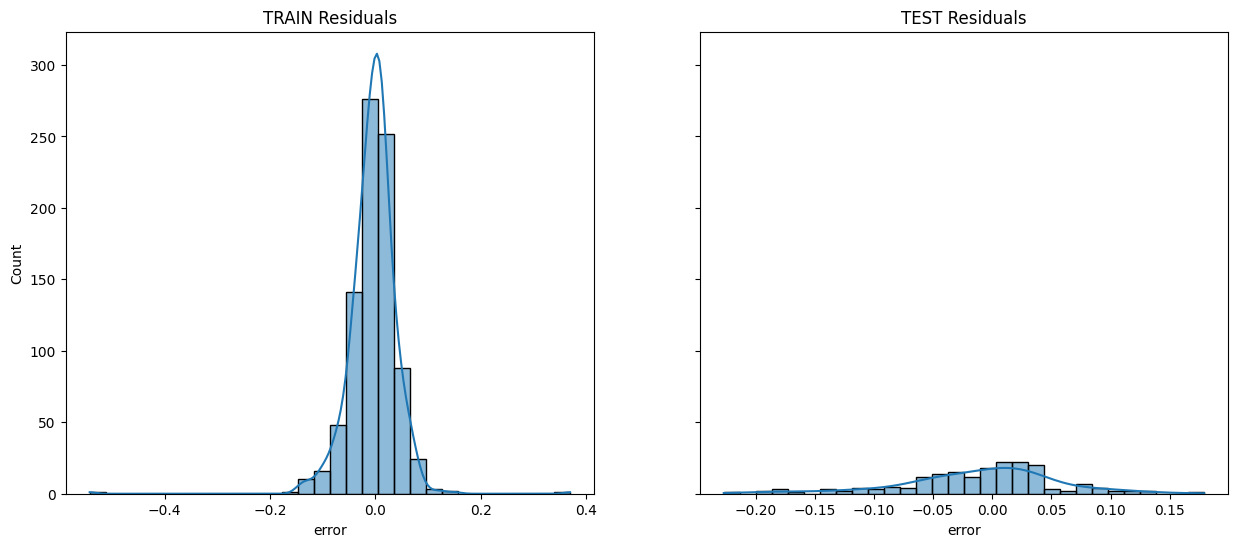

In [40]:
# Plot train-test hist results
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.histplot(dbplot_train["error"], bins=30, kde=True, ax=ax[0])
ax[0].set_title("TRAIN Residuals")
sns.histplot(dbplot_test["error"], bins=30, kde=True, ax=ax[1])
ax[1].set_title("TEST Residuals")

plt.show()

In [41]:
def normality_test(data, alpha=0.05):
    print("=== Normality Tests ===\n")

    # Helper for pass/fail
    def check_pvalue(p):
        return "PASSED normality ✓" if p > alpha else "FAILED normality ✗"

    # D'Agostino-Pearson
    stat, p = stats.normaltest(data)
    print("D'Agostino-Pearson Test")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {p:.4f}")
    print(f"  Result:    {check_pvalue(p)}\n")

    # Shapiro-Wilk
    stat, p = stats.shapiro(data)
    print("Shapiro-Wilk Test")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {p:.4f}")
    print(f"  Result:    {check_pvalue(p)}\n")

    # Kolmogorov-Smirnov (against standard normal)
    stat, p = stats.kstest(data, "norm")
    print("Kolmogorov-Smirnov Test")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {p:.4f}")
    print(f"  Result:    {check_pvalue(p)}\n")

    # Anderson-Darling
    result = stats.anderson(data)
    print("Anderson-Darling Test")
    print(f"  Statistic: {result.statistic:.4f}")

    # Check against critical values
    passed = []
    for sl, cv in zip(result.significance_level, result.critical_values):
        status = "PASSED" if result.statistic < cv else "FAILED"
        passed.append(result.statistic < cv)
        print(f"  At {sl}% level: critical={cv:.4f} → {status}")

    # Summary for Anderson
    if all(passed):
        print("  Overall Result: PASSED normality ✓")
    else:
        print("  Overall Result: FAILED normality ✗")

    print("\n=========================\n")

In [42]:
normality_test(dbplot_train["error"])

=== Normality Tests ===

D'Agostino-Pearson Test
  Statistic: 452.8218
  p-value:   0.0000
  Result:    FAILED normality ✗

Shapiro-Wilk Test
  Statistic: 0.8599
  p-value:   0.0000
  Result:    FAILED normality ✗

Kolmogorov-Smirnov Test
  Statistic: 0.4592
  p-value:   0.0000
  Result:    FAILED normality ✗

Anderson-Darling Test
  Statistic: 11.7825
  At 15.0% level: critical=0.5730 → FAILED
  At 10.0% level: critical=0.6530 → FAILED
  At 5.0% level: critical=0.7830 → FAILED
  At 2.5% level: critical=0.9140 → FAILED
  At 1.0% level: critical=1.0870 → FAILED
  Overall Result: FAILED normality ✗




In [43]:
normality_test(dbplot_test["error"])

=== Normality Tests ===

D'Agostino-Pearson Test
  Statistic: 14.6310
  p-value:   0.0007
  Result:    FAILED normality ✗

Shapiro-Wilk Test
  Statistic: 0.9680
  p-value:   0.0003
  Result:    FAILED normality ✗

Kolmogorov-Smirnov Test
  Statistic: 0.4404
  p-value:   0.0000
  Result:    FAILED normality ✗

Anderson-Darling Test
  Statistic: 2.0206
  At 15.0% level: critical=0.5640 → FAILED
  At 10.0% level: critical=0.6430 → FAILED
  At 5.0% level: critical=0.7710 → FAILED
  At 2.5% level: critical=0.8990 → FAILED
  At 1.0% level: critical=1.0700 → FAILED
  Overall Result: FAILED normality ✗




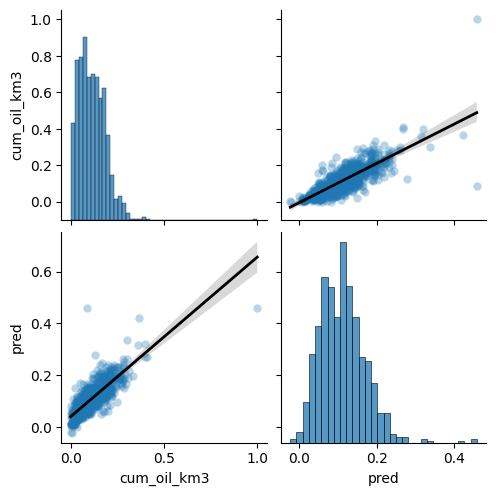

In [44]:
sns.pairplot(
    dbplot_train.drop(["error", "Xcoor", "Ycoor"], axis=1),
    diag_kind="hist",
    kind="reg",
    plot_kws={
        "line_kws": {"color": "black", "lw": 2},
        "scatter_kws": {"linewidths": 0, "alpha": 0.3},
    },
)
plt.show()

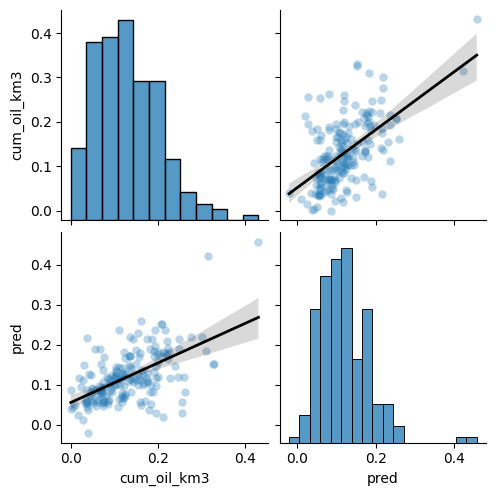

In [45]:
sns.pairplot(
    dbplot_test.drop(["error",'Xcoor', 'Ycoor'], axis=1),
    diag_kind="hist",
    kind="reg",
    plot_kws={
        "line_kws": {"color": "black", "lw": 2},
        "scatter_kws": {"linewidths": 0, "alpha": 0.3},
    },
)
plt.show()

### Analisis geoespacial de los residuos

In [46]:
Ierror = esda.moran.Moran(abs(residuals), knn)

In [47]:
print(
    "Errors  moransI: "
    + str(Ierror.I)
    + "  Z_I: "
    + str(Ierror.z_norm)
    + " p-value: "
    + str(Ierror.p_sim)
)

Errors  moransI: 0.051589927672066965  Z_I: 5.383543413890023 p-value: 0.001


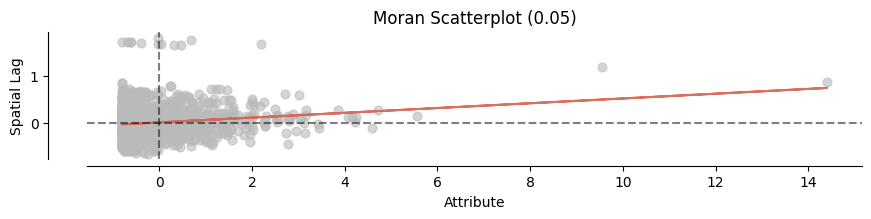

In [48]:
fig, ax = plt.subplots(figsize=(10, 20))
esdaplot.moran_scatterplot(Ierror, ax=ax)
plt.show()

In [49]:
lisa = Moran_Local(residuals, knn)

In [50]:
clusters = lisa.q
lisa.p_sim
sig = lisa.p_sim < 0.05      # True / False
clusters_sig = clusters.copy()
clusters_sig[~sig] = 0  # set non-significant to 0

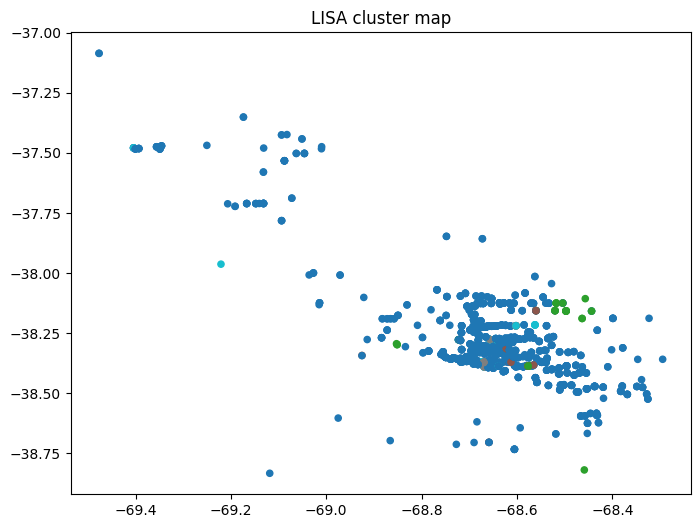

In [51]:
X = db["Xcoor"].values
Y = db["Ycoor"].values
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c=clusters_sig, cmap="tab10", s=20)
plt.title("LISA cluster map")
plt.show()

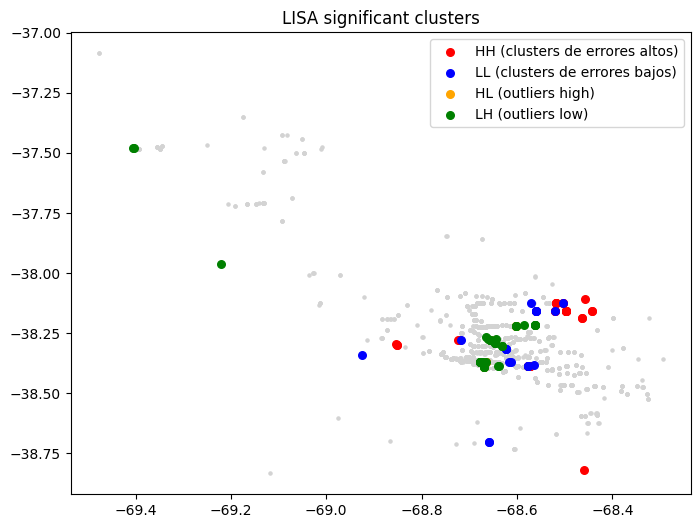

In [52]:
hh = (clusters == 1) & sig
ll = (clusters == 2) & sig
hl = (clusters == 3) & sig
lh = (clusters == 4) & sig

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c="lightgray", s=5)

plt.scatter(X[hh], Y[hh], c="red", s=30, label="HH (clusters de errores altos)")
plt.scatter(X[ll], Y[ll], c="blue", s=30, label="LL (clusters de errores bajos)")
plt.scatter(X[hl], Y[hl], c="orange", s=30, label="HL (outliers high)")
plt.scatter(X[lh], Y[lh], c="green", s=30, label="LH (outliers low)")

plt.legend()
plt.title("LISA significant clusters")
plt.show()

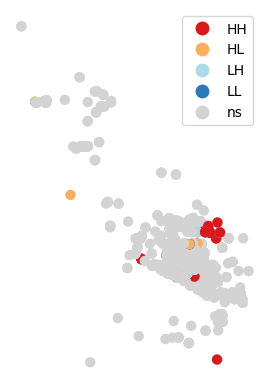

In [53]:
geometry = [Point(xy) for xy in zip(db["Xcoor"], db["Ycoor"])]
gdf = gpd.GeoDataFrame(db, geometry=geometry)
esdaplot.lisa_cluster(lisa, gdf)
plt.show()

In [54]:
g_local = G_Local(residuals, knn)

In [55]:
g_local.Zs  # Z-score por pozo
g_local.p_sim  # p-value por pozo (por simulación/permutaciones)
Zs = g_local.Zs
pvals = g_local.p_sim

sig = pvals < 0.05  # significativos

hotspots = (Zs > 0) & sig
coldspots = (Zs < 0) & sig

In [56]:
print("Hotspots:", hotspots.sum())
print("Coldspots:", coldspots.sum())

Hotspots: 47
Coldspots: 66


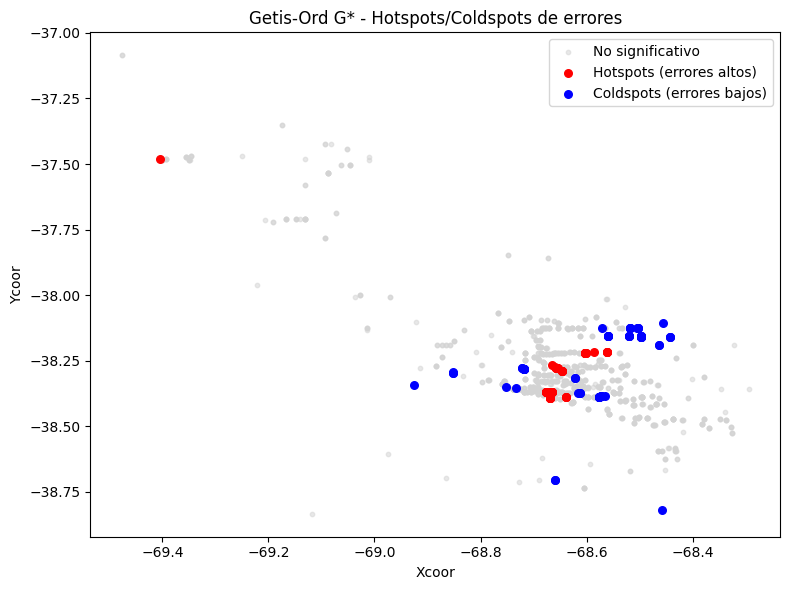

In [57]:
plt.figure(figsize=(8, 6))

plt.scatter(X, Y, c="lightgray", s=10, alpha=0.5, label="No significativo")
plt.scatter(X[hotspots], Y[hotspots], c="red", s=30, label="Hotspots (errores altos)")
plt.scatter(
    X[coldspots], Y[coldspots], c="blue", s=30, label="Coldspots (errores bajos)"
)

plt.xlabel("Xcoor")
plt.ylabel("Ycoor")
plt.title("Getis-Ord G* - Hotspots/Coldspots de errores")
plt.legend()
plt.tight_layout()
plt.show()

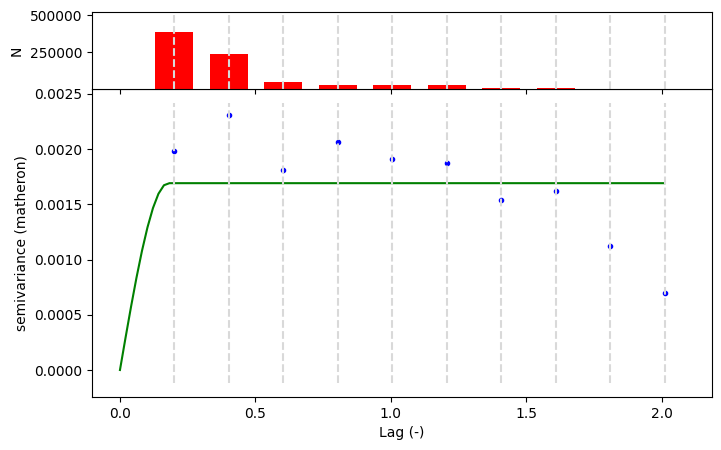

In [58]:
coordinates = np.column_stack((db["Xcoor"].values, db["Ycoor"].values))
V = skg.Variogram(coordinates, residuals)
V.plot()
plt.show()

In [59]:
lag_e = lag_spatial(knn, residuals)
corr = np.corrcoef(residuals, lag_e)[0, 1]
print("Spatial Lag Correlation:", corr)

Spatial Lag Correlation: -0.09578480016212212


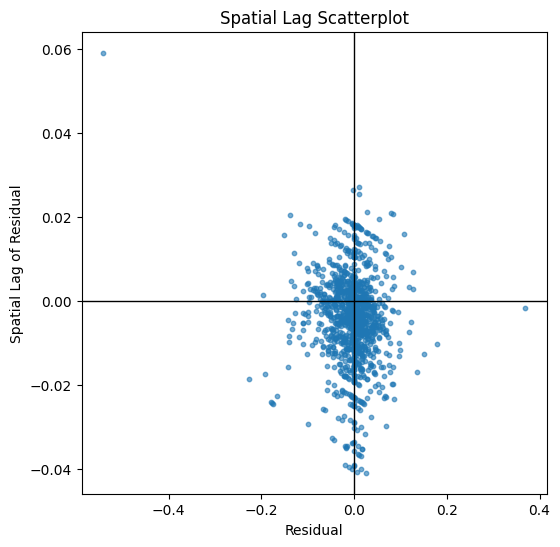

In [60]:
plt.figure(figsize=(6, 6))
plt.scatter(residuals, lag_e, s=10, alpha=0.6)
plt.axhline(0, color="k", linewidth=1)
plt.axvline(0, color="k", linewidth=1)
plt.xlabel("Residual")
plt.ylabel("Spatial Lag of Residual")
plt.title("Spatial Lag Scatterplot")
plt.show()

In [61]:
beta = np.polyfit(residuals, lag_e, 1)[0]
print("Spatial lag slope:", beta)

Spatial lag slope: -0.02214679012234224


#### Referencias

* https://github.com/dizhu-gis/SRGCNN

**Referencias Adicionales**

- **PyTorch Documentation:** [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)
- **Scikit-Learn Nearest Neighbors:** [https://scikit-learn.org/stable/modules/neighbors.html](https://scikit-learn.org/stable/modules/neighbors.html)
- **Graph Convolutional Networks Tutorial:** [https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)
- **Geographically Weighted Regression:** [https://geostatistics.tamu.edu/courses/GR1/Fall2006/lectures/Lecture9.pdf](https://geostatistics.tamu.edu/courses/GR1/Fall2006/lectures/Lecture9.pdf)